## 自己构建的网络

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
from keras.layers import Lambda
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as resnet50_pre
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inceptionV3_pre
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as xception_pre
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vgg16_pre
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as vgg19_pre
from keras.preprocessing import image   
from keras.optimizers import SGD, Adam
from keras.utils.np_utils import to_categorical
from tqdm import tqdm
from PIL import ImageFile  
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Input, Activation
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint  
import numpy as np
import pandas as pd
from glob import glob
import cv2                
import matplotlib.pyplot as plt    
import matplotlib.image as mpimg
%matplotlib inline 
import random
import os
import shutil
import h5py
import common
import pickle

Using TensorFlow backend.


In [4]:
def plot_info(file_name, acc_lengend, loss_lengend):
    with open(file_name, 'rb') as file:
        history = pickle.load(file)
        acc = history['acc']
        loss = history['loss']
        val_acc = history['val_acc']
        val_loss = history['val_loss']
    
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    plt.plot(range(1, len(acc) + 1), acc, label='acc')
    plt.plot(range(1, len(acc) + 1), val_acc, label='val_acc')
    plt.xticks(range(1, len(acc) + 1));
    plt.legend(loc=acc_lengend, shadow=True, fontsize='x-large')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.subplot(122)
    plt.plot(range(1, len(loss) + 1), loss, label='loss')
    plt.plot(range(1, len(loss) + 1), val_loss, label='val_loss')
    print(min(loss))
    print(min(val_loss))
    plt.xticks(range(1, len(loss) + 1));
    plt.legend(loc=loss_lengend, shadow=True, fontsize='x-large')
    plt.xlabel('Epochs')
    plt.ylabel('LogLoss');



0.4998620888576736
0.372977041813993


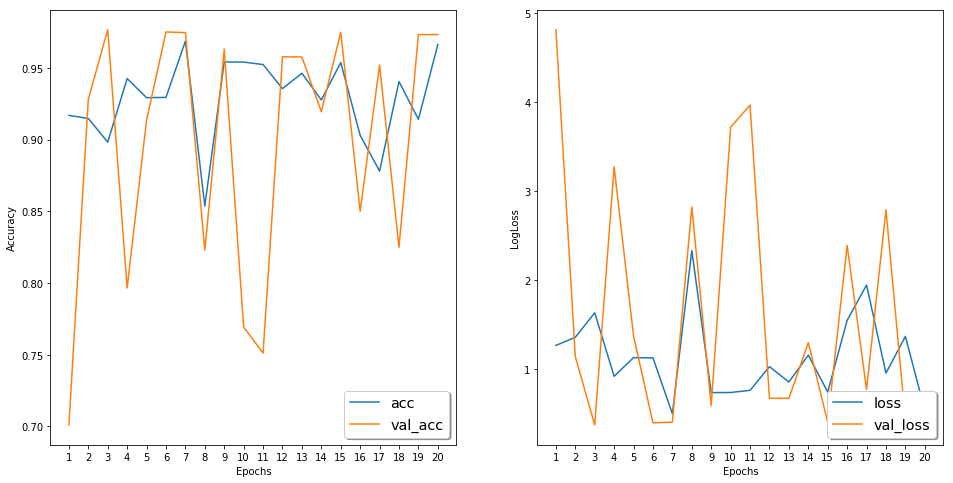

In [6]:
plot_info('vgg16_Adam_0.5_history.pkl', 'lower right', 'lower right')

In [9]:
def print_info(model_name):
    adam_3 = '{0}_Adam_0.3_history.pkl'.format(model_name)
    adam_5 = '{0}_Adam_0.5_history.pkl'.format(model_name)
    adam_7 = '{0}_Adam_0.7_history.pkl'.format(model_name)
    sgd_3 = '{0}_SGD_0.3_history.pkl'.format(model_name)
    sgd_5 = '{0}_SGD_0.5_history.pkl'.format(model_name)
    sgd_7 = '{0}_SGD_0.7_history.pkl'.format(model_name)
    with open(adam_3, 'rb') as file:
        history = pickle.load(file)
        loss_adam_3 = history['loss']
        val_loss_adam_3 = history['val_loss']
    print('adam 0.3', min(loss_adam_3), min(val_loss_adam_3))
    
    with open(adam_5, 'rb') as file:
        history = pickle.load(file)
        loss_adam_5 = history['loss']
        val_loss_adam_5 = history['val_loss']
    print('adam 0.5', min(loss_adam_5), min(val_loss_adam_5))
        
    with open(adam_7, 'rb') as file:
        history = pickle.load(file)
        loss_adam_7 = history['loss']
        val_loss_adam_7 = history['val_loss']
    print('adam 0.7', min(loss_adam_7), min(val_loss_adam_7))
        
    with open(sgd_3, 'rb') as file:
        history = pickle.load(file)
        loss_sgd_3 = history['loss']
        val_loss_sgd_3 = history['val_loss']
    print('sgd 0.3', min(loss_sgd_3), min(val_loss_sgd_3))
        
    with open(sgd_5, 'rb') as file:
        history = pickle.load(file)
        loss_sgd_5 = history['loss']
        val_loss_sgd_5 = history['val_loss']
    print('sgd 0.5', min(loss_sgd_5), min(val_loss_sgd_5))
        
    with open(sgd_7, 'rb') as file:
        history = pickle.load(file)
        loss_sgd_7 = history['loss']
        val_loss_sgd_7 = history['val_loss']
    print('sgd 0.7', min(loss_sgd_7), min(val_loss_sgd_7))  


In [10]:
print_info('vgg16')

adam 0.3 0.4418448792707706 0.43777374070292246
adam 0.5 0.4998620888576736 0.372977041813993
adam 0.7 0.8989952532956653 0.3979970933872095
sgd 0.3 0.025648708204028974 0.0343462420417986
sgd 0.5 0.03447115654422673 0.03535216963240943
sgd 0.7 0.04704843988031679 0.035664215980019606


In [11]:
print_info('vgg19')

adam 0.3 0.35398448235126273 0.3876117293090649
adam 0.5 0.4674166969350749 0.3379695095304379
adam 0.7 0.856542749408213 0.31190650404990156
sgd 0.3 0.02273160146381855 0.033152151013460265
sgd 0.5 0.032088031800518224 0.030946600693936028
sgd 0.7 0.042767566437170494 0.032719632694433454


In [12]:
print_info('resnet50')

adam 0.3 0.009348527739878534 0.029550443063153676
adam 0.5 0.4367409789772951 0.24012029126192216
adam 0.7 0.6004959155722724 0.26781029063047174
sgd 0.3 0.023439551142689845 0.0252854250806611
sgd 0.5 0.028303573043798488 0.027916292799613347
sgd 0.7 0.036979056990176715 0.027483011935055035


In [15]:
def model_train(key, dropout, optimizer, file_header):
    features_test = np.load('test_vgg16_features.npz')
    test_features = features_test['test']
    test_filenames = features_test['test_filename']
    
    model = Sequential()
    model.add(Dense(2048, input_shape=(512,), activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    

    model.load_weights('{0}.hdf5'.format(file_header))
    prediction = model.predict(test_features, batch_size=common.batch_size)
    prediction = prediction[:, 0].clip(0.01, 0.99)
    test_fileindex = np.array([os.path.splitext(os.path.split(filename)[1])[0] for filename in test_filenames])
    data = np.stack([test_fileindex, prediction], axis=1)
    tmp = pd.DataFrame(data, columns=['id', 'label'])
    tmp['id'] = tmp['id'].apply(pd.to_numeric)
    submit_frame = pd.read_csv('sample_submission.csv')
    result = pd.merge(submit_frame, tmp, on="id", how='left')
    result = result.rename(index=str, columns={"label_y": "label"})
    result.dropna(axis=0, subset=['label'], inplace=True)
    result[['id','label']].to_csv('{0}_predict.csv'.format(file_header),index=False)

In [16]:
model_train('vgg16', 0.5, SGD(lr=0.001), 'vgg16_SGD_0.5')

In [19]:
test_filenames = os.listdir(common.test_path + 'test/')
test_fileindex = np.array([os.path.splitext(os.path.split(filename)[1])[0] for filename in test_filenames])

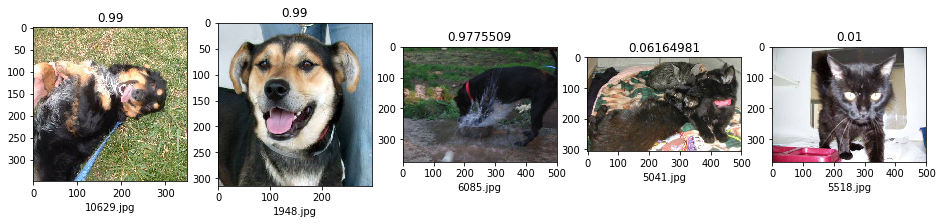

In [48]:
sample_filenames = random.sample(test_filenames, 5)
sample_fileindex = np.array([os.path.splitext(os.path.split(filename)[1])[0] for filename in sample_filenames])
result = pd.read_csv('xception_SGD_0.5_predict.csv')
plt.figure(figsize=(16, 9))
test_path = common.test_path + 'test/'
for i in range(len(sample_filenames)):
    plt.subplot(1, 5, i + 1)
    img = cv2.imread(test_path + sample_filenames[i])
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.xlabel(sample_filenames[i])
    #print(type(result[result['id'] == int(sample_fileindex[i])]['label']))
    #print(result[result['id'] == int(sample_fileindex[i])]['label'].iloc[0])
    #print(result[result['id'] == sample_fileindex[i]]['label'][0])
    #print(result[result['id'] == int(sample_fileindex[i])]['label'][0])
    plt.title(result[result['id'] == int(sample_fileindex[i])]['label'].iloc[0])